## Importing the required libraries


In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
from keras import regularizers

In [3]:
import os

In [4]:
mylist= os.listdir('../RawData')

In [5]:
type(mylist)


list

In [6]:
print(len(mylist))

1920


## Plotting the audio file's waveform and its spectrogram

In [7]:
data, sampling_rate = librosa.load('../RawData/f12 (3).wav')

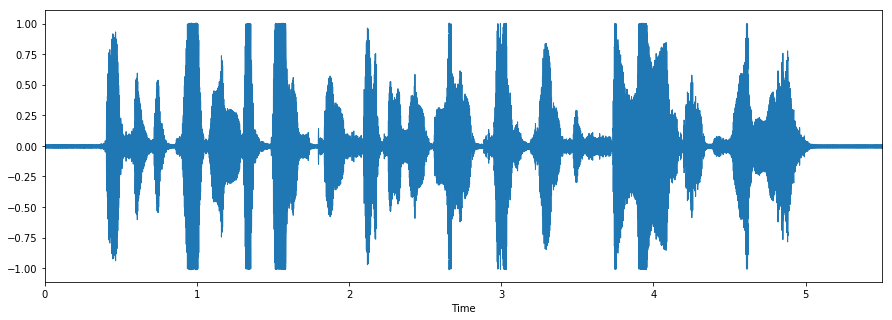

In [8]:
#% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)


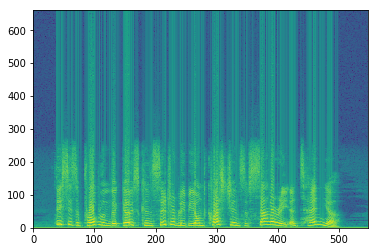

In [9]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('../RawData/f12 (3).wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [10]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
      #  feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [11]:
print(len(feeling_list))
labels = pd.DataFrame(feeling_list)

1200


In [12]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [13]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('../RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        


In [14]:
df[:15]

,feature
0,"[-70.2677641610773, -70.2677641610773, -70.267..."
1,"[-65.70765240065282, -65.70765240065282, -63.1..."
2,"[-65.4824988827423, -65.4824988827423, -65.482..."
3,"[-64.52844910346735, -64.52844910346735, -64.5..."
4,"[-62.36431052745468, -59.93472513811134, -61.8..."
5,"[-71.28834653966786, -71.28834653966786, -71.2..."
6,"[-61.18919606825368, -60.35289860648416, -62.1..."
7,"[-54.71531853523789, -55.71629725947883, -57.2..."
8,"[-73.03060130615042, -72.72179580419063, -72.4..."
9,"[-50.268392570208235, -51.05535503679801, -48...."


In [15]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [16]:
newdf = pd.concat([df3,labels], axis=1)

In [17]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [18]:
rnewdf[:5]


,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-57.447461,-58.896493,-58.751002,-57.405669,-60.078475,-63.426811,-62.638537,-61.082741,-60.234652,male_calm
1,-65.707652,-65.707652,-63.114722,-61.518999,-61.097138,-63.424602,-63.720067,-56.854608,-55.168972,-54.640002,...,-39.792147,-40.613166,-41.209201,-41.439204,-43.994282,-49.399616,-50.591601,-49.144064,-48.705645,female_calm
2,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,...,-31.346553,-34.310774,-35.800705,-35.936112,-37.631846,-40.119408,-41.662903,-41.323644,-40.710780,male_calm
3,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-65.928222,...,-48.674306,-48.596082,-47.602751,-43.049195,-42.659546,-43.188561,-44.001237,-43.610100,-44.698259,female_calm
4,-62.364311,-59.934725,-61.869600,-67.495764,-71.071811,-65.679826,-63.394396,-65.503349,-61.856639,-60.005421,...,-39.071328,-41.897121,-40.865430,-38.290605,-36.372397,-37.915779,-40.026125,-43.383777,-43.965398,male_calm


## Shuffling the Dataset

In [19]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
1137,-23.370328,-22.991479,-14.360472,-6.680718,-2.668504,-1.909457,-5.410734,-7.193846,-5.948755,-6.512120,...,-5.241548,-5.398290,-4.489194,-4.170420,-2.760769,-1.080888,-0.033273,0.568928,3.092341,male_happy
46,-62.357663,-60.535471,-61.316843,-62.192958,-63.016798,-60.831608,-61.015272,-61.579481,-62.769567,-62.236340,...,-27.774536,-27.380441,-27.209472,-27.213353,-27.588573,-27.872451,-28.432547,-27.225237,-25.391351,male_calm
58,-56.881378,-53.240963,-53.108598,-58.342936,-60.727296,-55.919524,-55.301609,-55.637446,-55.671107,-56.805252,...,-57.439754,-56.233542,-56.944048,-57.740971,-60.285250,-63.966644,-66.107582,-63.002538,-60.625133,male_calm
502,-51.905513,-50.803438,-50.226068,-50.311341,-51.817172,-51.475405,-50.128191,-50.420363,-51.461924,-50.583123,...,-31.646653,-28.005782,-30.625338,-36.442667,-37.959371,-38.148485,-37.082388,-34.643008,-30.653570,male_sad
839,-54.897441,-55.061032,-54.983695,-55.102022,-55.289954,-55.346702,-55.382404,-55.439658,-55.337597,-54.012888,...,-35.287239,-39.428942,-41.273553,-40.047037,-40.112812,-43.898186,-46.512260,-45.556203,-43.528693,female_fearful
709,-44.500762,-44.500762,-44.500762,-44.500762,-44.500762,-44.500762,-44.500762,-44.500762,-44.500762,-44.500762,...,-39.405512,-32.880433,-21.474274,-22.463821,-28.607669,-25.395961,-25.901439,-24.337984,-15.169855,female_angry
579,-54.135109,-54.135109,-54.135109,-54.135109,-54.135109,-54.135109,-54.135109,-54.135109,-54.135109,-54.135109,...,-53.893908,-54.098901,-53.959108,-53.267341,-53.393110,-53.997253,-54.044434,-53.462740,-53.641251,female_angry
763,-48.035992,-48.035992,-48.035992,-48.035992,-48.035992,-48.035992,-48.035992,-47.938800,-47.644461,-47.549335,...,-48.035992,-48.035992,-48.035992,-48.035992,-48.035992,-48.035992,-48.035992,-48.035992,-48.035992,female_angry
112,-58.327258,-54.953269,-55.248724,-53.967301,-51.944891,-52.322751,-53.839473,-54.893931,-51.611972,-52.376585,...,-43.847284,-43.556649,-42.028376,-40.557638,-43.097682,-42.761174,-42.750999,-45.633865,-44.306819,male_calm
1159,-2.346513,-4.708540,-9.908000,-9.604340,-9.175136,-9.829357,-9.926720,-10.046444,-10.696881,-11.749737,...,-10.909528,-12.287178,-12.257010,-11.220351,-11.043716,-12.589155,-12.230987,-10.666864,-6.847253,male_sad


In [20]:
rnewdf=rnewdf.fillna(0)  #Replaces NULL values with 0

## Dividing the data into test and train

In [21]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8   #dividing the Dataset in 80/20
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [22]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
1138,-31.980330,-34.134652,-35.997043,-35.862972,-36.733599,-37.994280,-40.591646,-35.662814,-30.251110,-26.410415,...,-24.177086,-26.008901,-28.027075,-30.828884,-31.061959,-27.995091,-28.250276,-20.617224,-13.429229,male_happy
390,-71.188637,-71.188637,-71.188637,-71.188637,-71.188637,-69.602972,-68.462377,-67.832988,-65.815999,-65.290115,...,-59.432881,-57.374782,-55.124635,-55.970205,-60.561055,-61.474515,-60.195324,-56.605395,-59.115601,male_sad
520,-53.265220,-53.771242,-53.365950,-54.065362,-54.984349,-51.845011,-49.563205,-48.634347,-48.539895,-49.393295,...,-41.534051,-42.170543,-41.020291,-38.957930,-38.296375,-38.443544,-39.312915,-40.316897,-35.116073,male_sad
683,-45.871581,-45.871581,-45.871581,-45.871581,-45.871581,-45.871581,-45.871581,-45.871581,-45.871581,-45.871581,...,-34.769214,-35.539154,-38.184049,-36.689138,-35.603159,-35.669232,-35.926710,-35.287492,-34.311394,female_angry
974,-14.793880,-17.510644,-28.352653,-28.147649,-28.767751,-30.541570,-30.408878,-30.230988,-30.723164,-31.899063,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_angry
454,-62.598881,-62.100326,-61.780571,-61.741726,-62.048746,-62.413818,-62.598881,-62.598881,-62.598881,-62.598881,...,-54.009343,-53.810804,-55.463629,-58.231921,-60.387967,-57.817822,-56.916338,-56.795908,-57.186976,male_sad
350,-47.260843,-44.142711,-44.478883,-47.246907,-50.295858,-49.791635,-48.512130,-44.795408,-43.321731,-44.179745,...,-35.291766,-38.255193,-39.402966,-38.522801,-38.838060,-39.165993,-40.849884,-41.738117,-41.969712,male_happy
378,-56.162255,-55.486571,-58.117347,-61.662764,-61.764235,-61.780832,-61.780832,-61.780832,-61.780832,-61.780832,...,-23.961060,-24.696315,-24.201457,-25.758725,-27.005401,-27.926363,-27.884412,-26.517563,-27.867812,male_happy
1075,-12.075556,-9.280471,-8.570027,-9.095344,-8.302023,-7.739111,-7.499095,-4.971588,-3.119136,-0.009929,...,-11.323505,-15.787580,-20.970462,-18.939516,-17.515012,-9.545071,-6.332156,-0.149038,3.786672,male_fearful
920,-56.595426,-56.793076,-55.759028,-53.813961,-54.781144,-54.527846,-55.011299,-56.331947,-56.169859,-55.770736,...,-49.854436,-51.720222,-52.330480,-52.576958,-51.651296,-52.722420,-51.558589,-51.441206,-51.354306,male_fearful


In [23]:
trainfeatures = train.iloc[:, :-1]     #storing all the features except last column(labels)

In [24]:
trainlabel = train.iloc[:, -1:]  #storing the last column(labels)

In [25]:
testfeatures = test.iloc[:, :-1]

In [26]:
testlabel = test.iloc[:, -1:]

In [27]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))  #is used to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
X_train.shape

(943, 216)

In [30]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

## Changing dimension for CNN model

In [31]:
print(x_traincnn.shape)
print(x_testcnn.shape)

(943, 216, 1)
(257, 216, 1)


In [32]:
model = Sequential()
#keras.layers.Conv1D(filters, kernel_size, padding='same')
model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_2 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)           82048     
__________

In [34]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

## Training the model by using model.fit 

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [35]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 92.22%


In [36]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

257/257 [==============================] - 1s 2ms/step


In [37]:
preds

array([[1.7024743e-11, 1.5759253e-11, 5.3653132e-20, ..., 1.2056141e-05,
        8.1036956e-04, 3.4001940e-03],
       [4.0816220e-05, 9.8469085e-01, 1.2874494e-05, ..., 3.4376964e-07,
        3.8304970e-06, 3.7530856e-06],
       [3.4144399e-23, 0.0000000e+00, 1.3759739e-23, ..., 9.9997115e-01,
        1.8224899e-05, 1.0652004e-05],
       ...,
       [1.2759632e-06, 3.0065772e-07, 9.9715316e-01, ..., 2.6631286e-09,
        3.6256784e-10, 8.7327240e-10],
       [2.5228700e-10, 3.1225093e-21, 1.3173692e-16, ..., 9.9597079e-01,
        7.1466806e-05, 2.3194363e-04],
       [5.5649803e-06, 2.5681980e-14, 1.7156462e-12, ..., 9.9122775e-01,
        1.7607796e-04, 6.3264146e-03]], dtype=float32)

In [38]:
preds1=preds.argmax(axis=1)

In [39]:
preds1

array([6, 1, 7, 2, 4, 6, 6, 2, 7, 1, 4, 7, 5, 8, 7, 8, 7, 7, 8, 2, 8, 3,
       0, 6, 5, 8, 1, 9, 7, 5, 2, 0, 3, 3, 8, 5, 0, 2, 9, 8, 5, 9, 6, 8,
       8, 5, 9, 9, 4, 5, 9, 6, 8, 6, 1, 3, 5, 8, 5, 6, 8, 2, 9, 1, 7, 6,
       8, 8, 8, 0, 9, 7, 7, 3, 4, 2, 6, 6, 5, 7, 9, 9, 4, 7, 5, 6, 4, 3,
       1, 9, 0, 5, 7, 8, 8, 5, 0, 8, 7, 0, 4, 5, 4, 8, 1, 4, 1, 9, 6, 3,
       4, 4, 7, 9, 1, 6, 6, 0, 7, 8, 6, 4, 5, 4, 0, 6, 0, 0, 5, 9, 9, 7,
       9, 8, 9, 1, 5, 4, 4, 1, 2, 8, 1, 9, 9, 9, 4, 7, 0, 9, 5, 7, 7, 3,
       6, 3, 9, 3, 2, 8, 8, 1, 5, 7, 9, 6, 9, 6, 0, 9, 3, 0, 5, 8, 8, 5,
       0, 8, 0, 5, 7, 3, 8, 8, 9, 2, 5, 7, 9, 8, 3, 9, 3, 2, 8, 6, 0, 5,
       8, 9, 3, 3, 4, 2, 2, 5, 1, 3, 9, 7, 7, 9, 8, 6, 9, 5, 5, 7, 9, 8,
       8, 0, 5, 1, 0, 8, 2, 9, 9, 8, 2, 4, 8, 7, 1, 6, 8, 5, 9, 6, 0, 5,
       6, 3, 2, 7, 8, 3, 7, 2, 5, 5, 9, 9, 2, 7, 7], dtype=int64)

In [40]:
abc = preds1.astype(int).flatten()

In [41]:
predictions = (lb.inverse_transform((abc)))

In [42]:
predictions[:10]


array(['male_calm', 'female_calm', 'male_fearful', 'female_fearful',
       'female_sad', 'male_calm', 'male_calm', 'female_fearful',
       'male_fearful', 'female_calm'], dtype=object)

In [43]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_calm
1,female_calm
2,male_fearful
3,female_fearful
4,female_sad
5,male_calm
6,male_calm
7,female_fearful
8,male_fearful
9,female_calm


In [44]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [45]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,female_calm
2,male_fearful
3,female_fearful
4,female_sad
5,male_calm
6,male_calm
7,female_angry
8,male_fearful
9,female_sad


In [46]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [47]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_happy,female_happy
171,female_angry,female_angry
172,male_angry,male_angry
173,male_happy,male_happy
174,male_happy,male_happy
175,male_angry,male_angry
176,female_angry,female_angry
177,male_happy,male_happy
178,female_angry,female_angry
179,male_angry,male_angry


In [48]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,19
female_calm,14
female_fearful,18
female_happy,22
female_sad,17
male_angry,32
male_calm,25
male_fearful,31
male_happy,41


In [49]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,20
female_calm,16
female_fearful,18
female_happy,19
female_sad,18
male_angry,32
male_calm,25
male_fearful,31
male_happy,40


In [50]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook


In [87]:
data, sampling_rate = librosa.load('output10.wav')

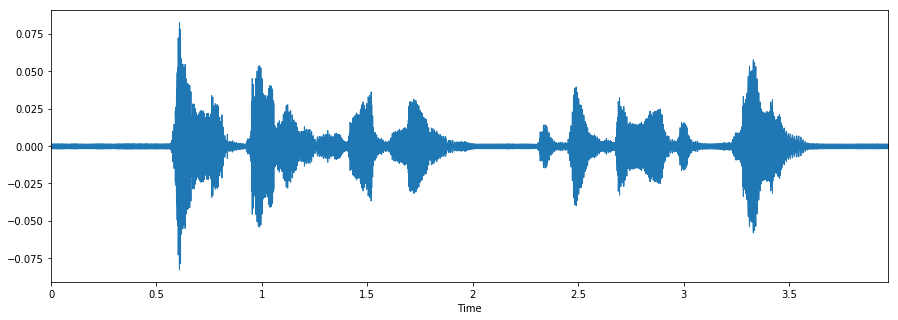

In [88]:
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [89]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [90]:
livedf2= pd.DataFrame(data=livedf2)

In [91]:
livedf2 = livedf2.stack().to_frame().T

In [92]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-42.820799,-41.879019,-41.79613,-41.672019,-42.057247,-36.722322,-31.798767,-29.665691,-28.737719,-27.070094,...,-24.673594,-24.244009,-26.617028,-27.4168,-28.629021,-29.346582,-28.693097,-28.218818,-25.271538,-23.246948


In [93]:
twodim= np.expand_dims(livedf2, axis=2)

In [94]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 16ms/step


In [95]:
livepreds

array([[1.1961309e-04, 6.6898486e-14, 5.0145849e-03, 1.1708670e-05,
        1.4979160e-05, 8.4136730e-07, 1.6664516e-03, 9.9082774e-01,
        2.3472591e-04, 2.1093907e-03]], dtype=float32)

In [96]:

livepreds1=livepreds.argmax(axis=1)

In [97]:
liveabc = livepreds1.astype(int).flatten()

In [98]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_fearful'], dtype=object)